In [102]:
from collections import Counter
import glob
import matplotlib.pyplot as plt
import numpy as np
import PIL
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torchvision import transforms
import torchvision.datasets as datasets



print('done')

done


In [103]:
# mnist data reader

transform = transforms.Compose([
    transforms.ToTensor()
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 100

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x12a722438>,
 <torch.utils.data.dataloader.DataLoader at 0x122a13240>)

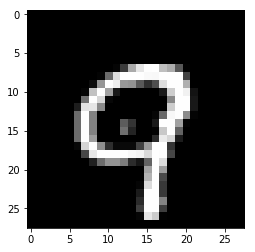

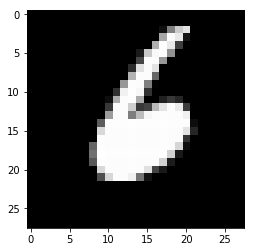

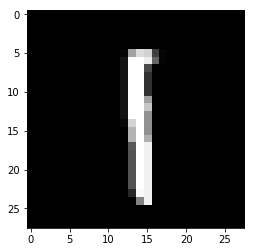

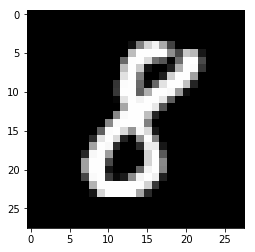

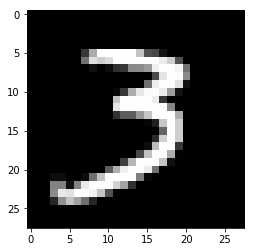

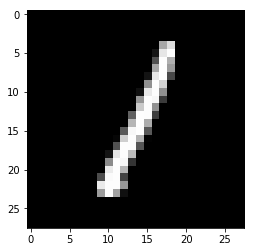

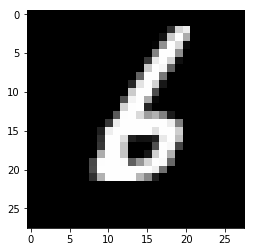

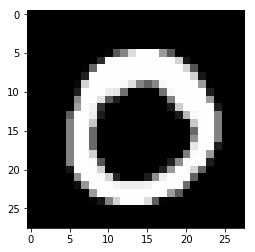

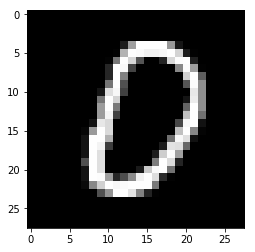

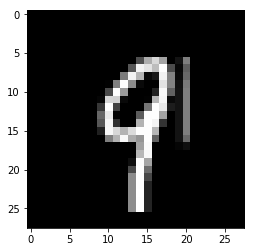

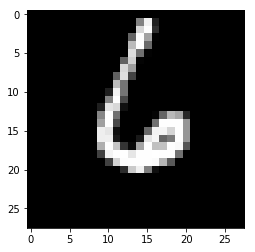

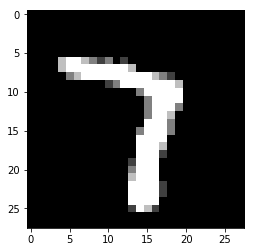

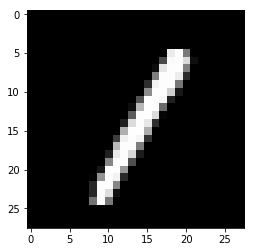

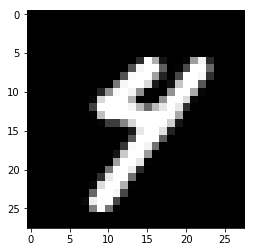

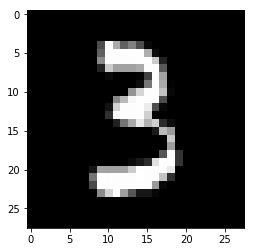

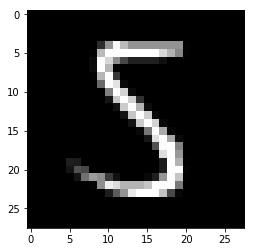

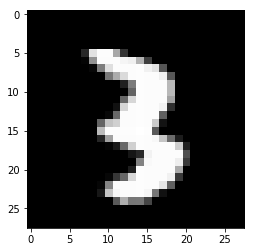

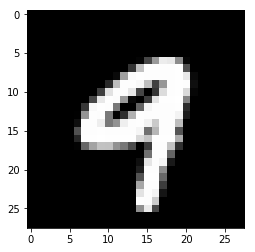

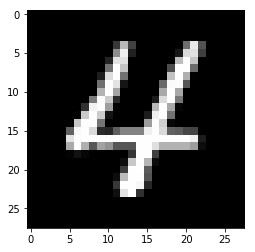

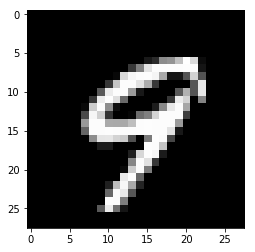

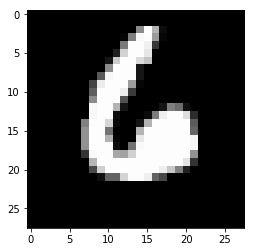

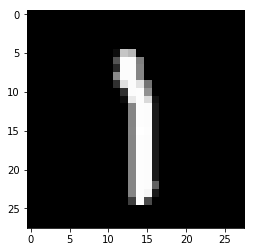

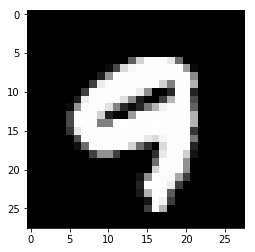

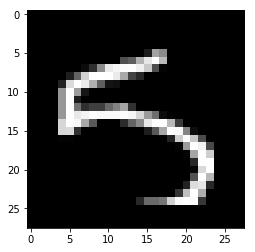

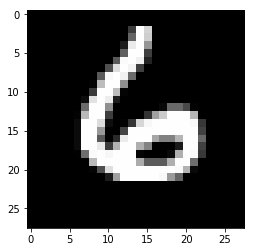

In [107]:
# mnist data reader

def gray_to_rgb(x):
    x = np.array(x[0,:,:]) 
    return torch.tensor(np.stack([x,x,x], axis = -1).reshape((3,28,28)))

normalize = transforms.Normalize((0.1307,), (0.1307,))

transform = transforms.Compose([
    transforms.ToTensor(),
    normalize
])

train_set = datasets.MNIST(root='./', train=True, download=True, transform=transform)
test_set = datasets.MNIST(root='./', train=False, download=True, transform=transform)

batch_size = 25

train_loader = torch.utils.data.DataLoader(
                 dataset=train_set,
                 batch_size=batch_size,
                 shuffle=True)
test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=batch_size,
                shuffle=False)
train_loader, test_loader

for i, (inputs, outputs) in enumerate(train_loader):
    for image in inputs.numpy():
        image = image.reshape((28,28))
        plt.imshow(image, cmap = 'gray')
        plt.show()
    break

In [119]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32,3)
        self.conv3 = nn.Conv2d(32,64,3)
        self.fc1 = nn.Linear(64 * 9, 120)
        self.fc2 = nn.Linear(120,120)
        self.encoding = nn.Linear(120,25)
        self.fc3 = nn.Linear(25,10)
        
        
    def forward(self, x):
        x = x.reshape((x.shape[0],1,28,28))
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.reshape((x.shape[0], x.shape[1] * x.shape[2] * x.shape[3]))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        encoded = torch.relu(self.encoding(x))
        
        return self.fc3(encoded), encoded
        

    
classifier = Classifier()
classifier(torch.randn((10,1,28,28)))
classifier

Classifier(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=120, bias=True)
  (encoding): Linear(in_features=120, out_features=25, bias=True)
  (fc3): Linear(in_features=25, out_features=10, bias=True)
)

In [120]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(classifier.parameters(), lr=0.01, momentum = 0.9)
print('done')

done


In [121]:
def fit(model, train_loader, metric, optimizer, epochs = 5, log_every = 100):
    for j in range(epochs):
        total = 0
        correct = 0
        losses = []
        for i, (inputs, outputs) in enumerate(train_loader):
            optimizer.zero_grad()
            predictions, encoded = model(inputs)
            loss = metric(predictions, outputs)  
            loss += 0.0001 * torch.sum(torch.abs(encoded))
            correct += sum(torch.max(predictions, -1)[1] == outputs).item()
            total += predictions.shape[0]
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
            if i%log_every == 0:
                print(j, np.mean(losses), correct/total)
                
fit(classifier, train_loader, criterion, optimizer, epochs = 5, log_every = 100)

0 2.3010363578796387 0.12
0 2.110275996793615 0.25425742574257426
0 1.4850137254491966 0.4981094527363184
0 1.1291501700779132 0.6300332225913621
0 0.9351893971462797 0.7003491271820449
0 0.7987362760121 0.7485029940119761
0 0.6984344179960534 0.7832279534109817
0 0.6295850877244871 0.8070756062767475
0 0.576254829303937 0.8256179775280899
0 0.5336064486438771 0.8406215316315205
0 0.49353078427118857 0.853906093906094
0 0.4605658201739314 0.8647411444141689
0 0.4349648783868993 0.873638634471274
0 0.4135872102374759 0.8807993850883935
0 0.39311287607425965 0.8874232690935047
0 0.3751577460278399 0.8933244503664224
0 0.35956895598754296 0.8983385384134915
0 0.3467931072876462 0.9026455026455027
0 0.33345752272512896 0.9068517490283176
0 0.3229600049159453 0.9101525512887954
0 0.3120781236692615 0.9135632183908046
0 0.30237926999333076 0.9166492146596859
0 0.2935728826617203 0.9194729668332576
0 0.2851840519613025 0.9220165145588874
1 0.11404092609882355 0.96
1 0.08677045772276303 0.9821

In [122]:
# Monitor accuracy in test and train 
# Quality monitoring visualizaing incorrect and correct in test and train
# Transfer learning
# Image augmentations
# Visualzaing what conv layers learn
# Visualize what activations learn

def evaluate(model, test_loader):
    correct = 0
    total = 0
    for i, data in enumerate(test_loader):
        inputs, outputs = data
        predictions, encoded = model(inputs)
        predictions = torch.max(predictions, -1)[1]
        correct += sum(predictions == outputs).item()
        total += predictions.shape[0]
    return correct / total
        
        
evaluate(classifier, test_loader)

0.9869

activating neurons for digit  0


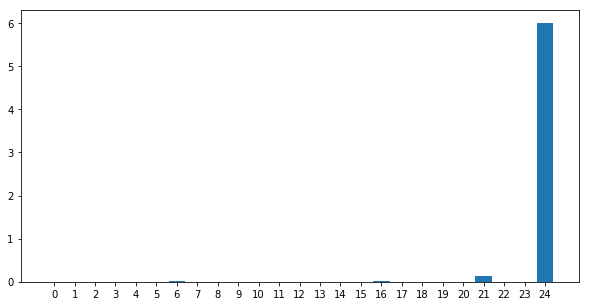

activating neurons for digit  1


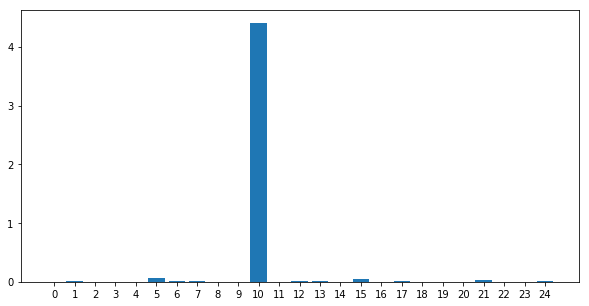

activating neurons for digit  2


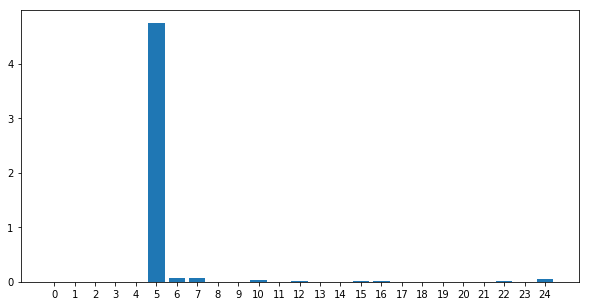

activating neurons for digit  3


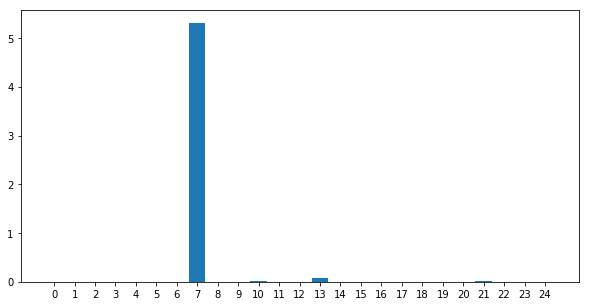

activating neurons for digit  4


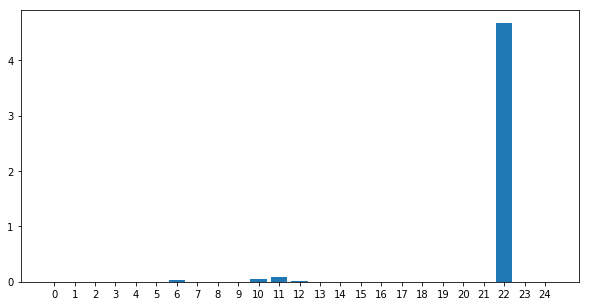

activating neurons for digit  5


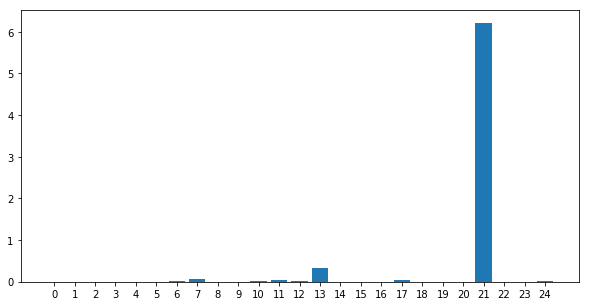

activating neurons for digit  6


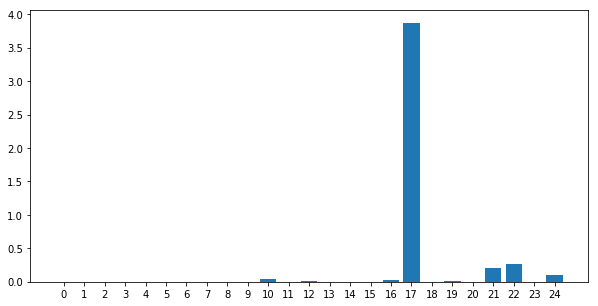

activating neurons for digit  7


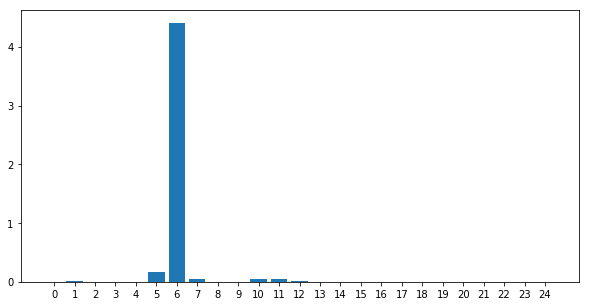

activating neurons for digit  8


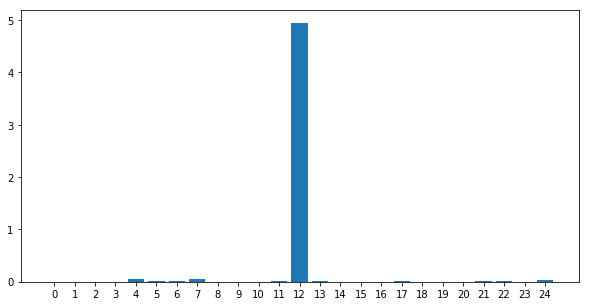

activating neurons for digit  9


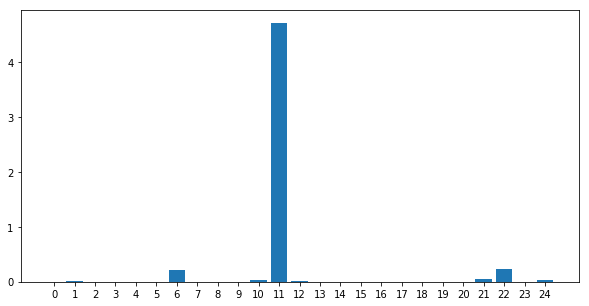

In [123]:
# find which neurons get activated for a given digit

def get_activating_neurons(digit, test_loader):
    d = defaultdict(list)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()].append(rep.detach().numpy())
    d[digit] = np.array(d[digit])
    d[digit] = np.mean(d[digit], axis = 0)
    plt.figure(figsize=(10,5))
    plt.bar(range(0,25), d[digit])
    plt.xticks(range(0,25))
    plt.show()
        

for i in range(0,10):
    print('activating neurons for digit ', i)
    get_activating_neurons(i, test_loader)

digit activation graph of neuron 0


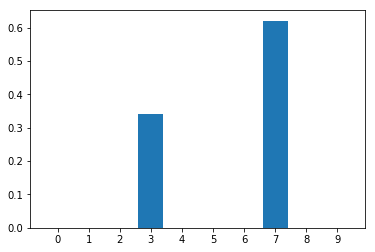

digit activation graph of neuron 1


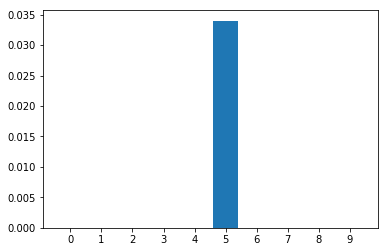

digit activation graph of neuron 2


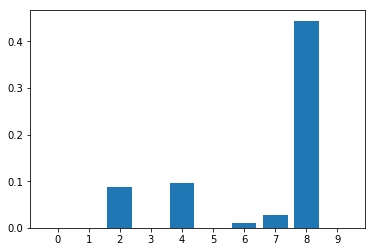

digit activation graph of neuron 3


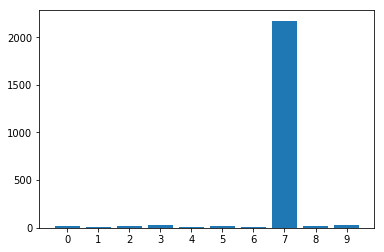

digit activation graph of neuron 4


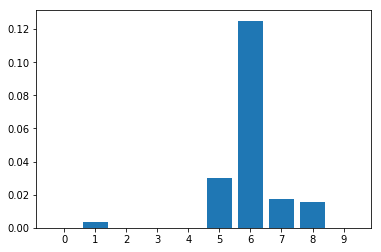

digit activation graph of neuron 5


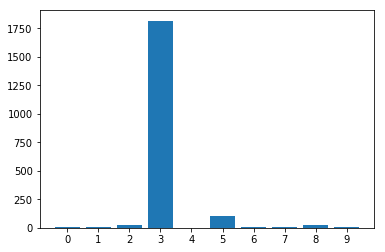

digit activation graph of neuron 6


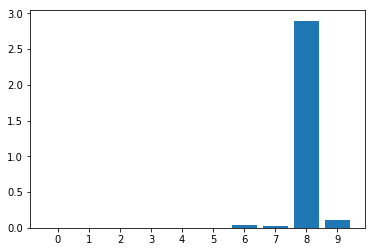

digit activation graph of neuron 7


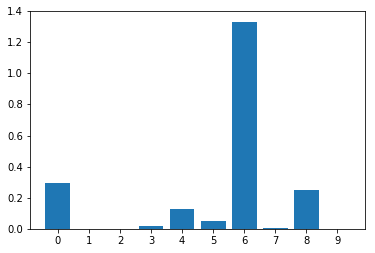

digit activation graph of neuron 8


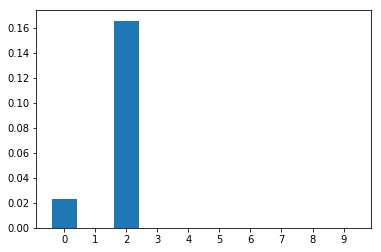

digit activation graph of neuron 9


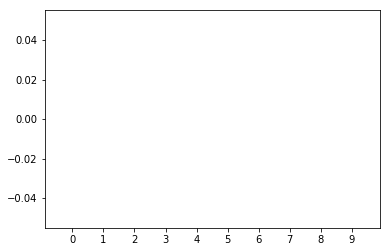

digit activation graph of neuron 10


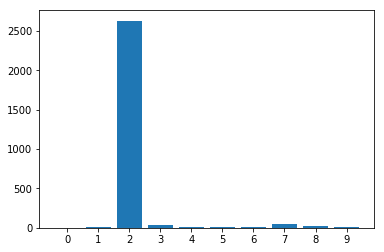

digit activation graph of neuron 11


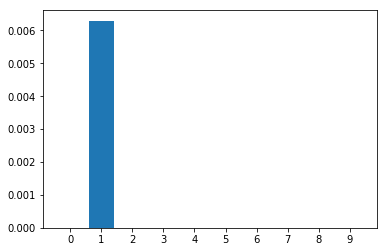

digit activation graph of neuron 12


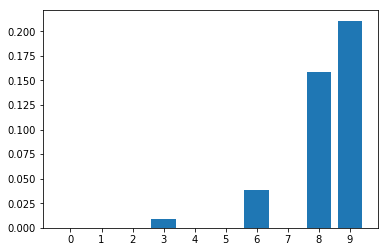

digit activation graph of neuron 13


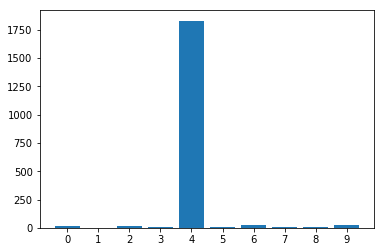

digit activation graph of neuron 14


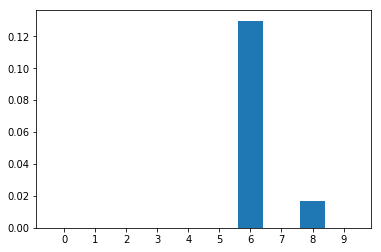

digit activation graph of neuron 15


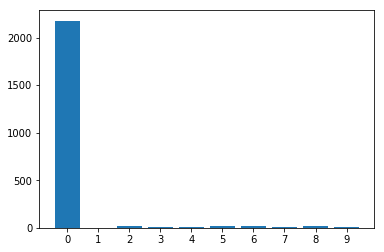

digit activation graph of neuron 16


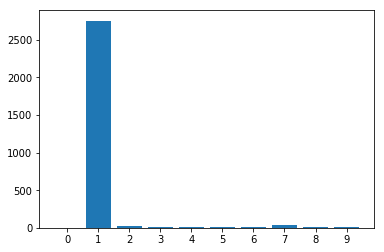

digit activation graph of neuron 17


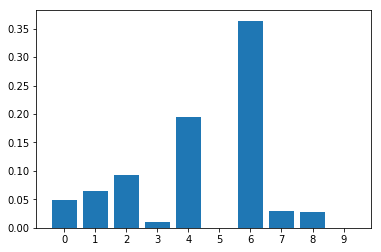

digit activation graph of neuron 18


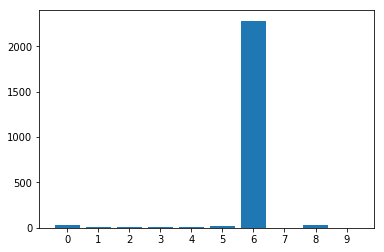

digit activation graph of neuron 19


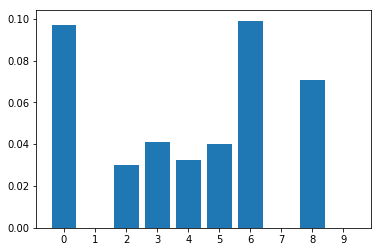

digit activation graph of neuron 20


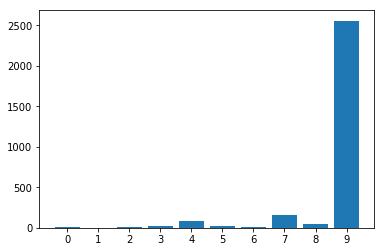

digit activation graph of neuron 21


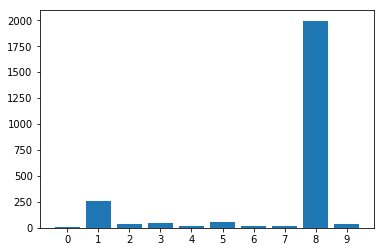

digit activation graph of neuron 22


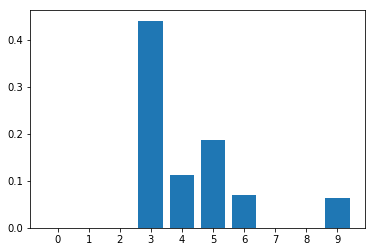

digit activation graph of neuron 23


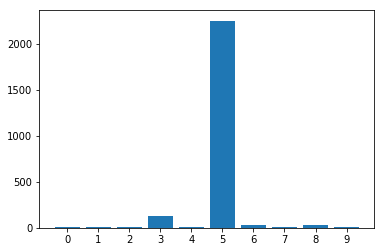

digit activation graph of neuron 24


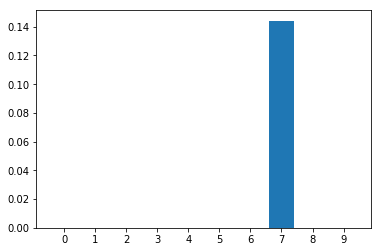

In [28]:
### find digits which activate a neuron


def get_activating_digit(dim_number, test_loader):
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        predictions, encoded = classifier(inputs)
        for output, rep in zip(outputs, encoded):
            d[output.item()] += rep.detach().numpy()[dim_number]
    d = sorted(d.items())        
    x = [ e[0] for e in d ]
    y = [ e[1] for e in d ]
    plt.bar(x, y)
    plt.xticks(range(0,10), range(0,10))
    plt.show()

for i in range(25):
    print("digit activation graph of neuron " + str(i))
    get_activating_digit(i, test_loader)
        
        
    


ACTIVATION IMAGES AND HEATMAPS


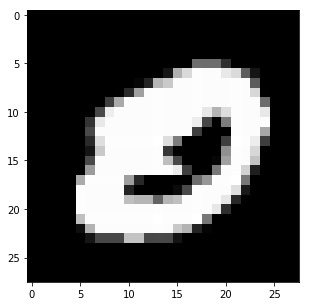

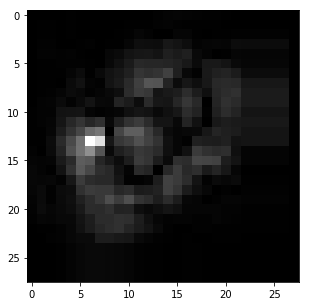

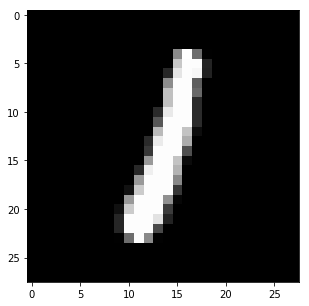

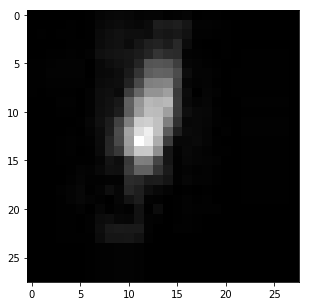

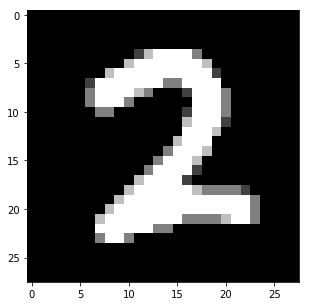

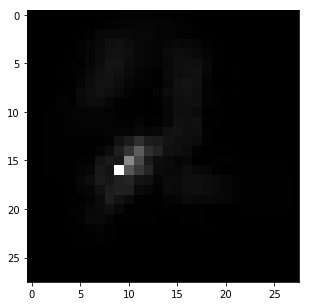

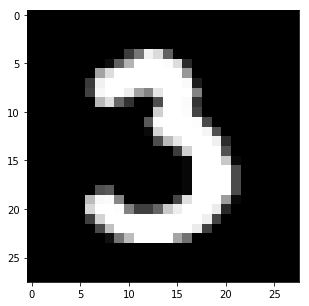

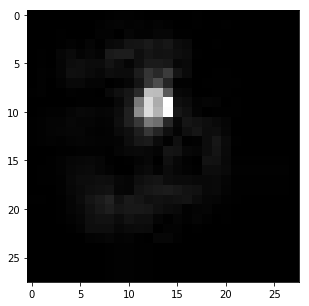

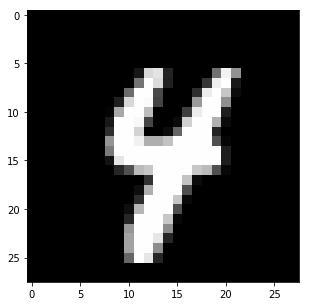

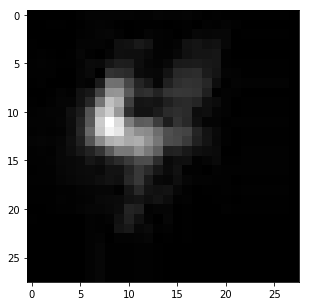

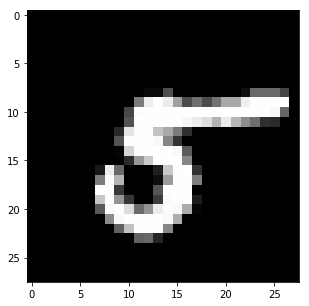

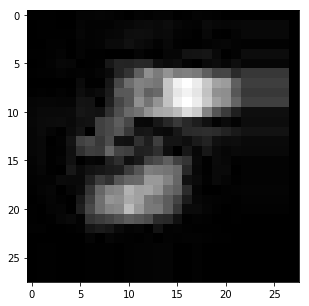

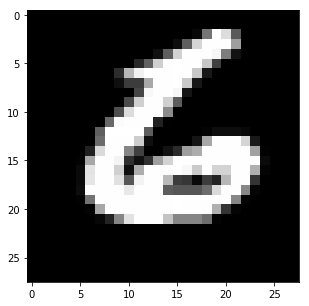

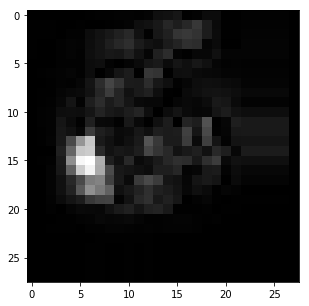

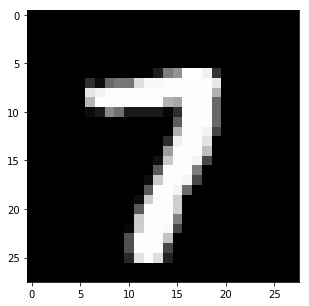

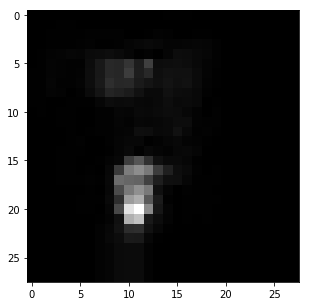

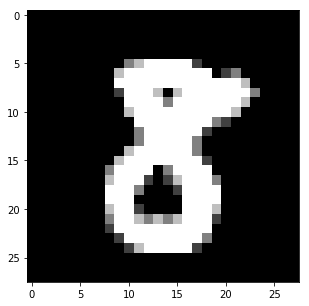

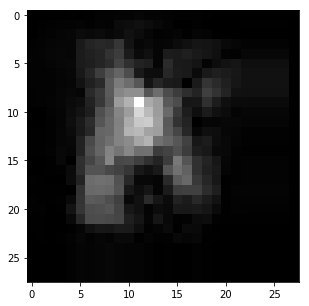

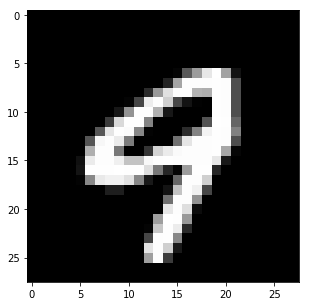

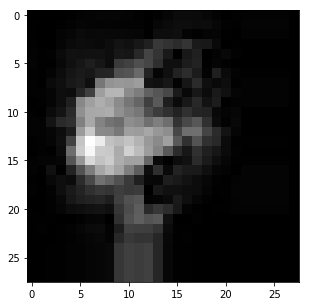

In [155]:
# Find what part of image contributes to probability score by occluding image


def get_activation_heatmap(digit, test_loader):
    digit_images = None
    d = defaultdict(lambda : 0)
    for inputs, outputs in test_loader:
        for image, output in zip(inputs, outputs):
            if output.item() == digit:
                digit_image = image
    
   
    heat_map = np.zeros((28,28))
    

    digit_image = digit_image.reshape((28,28,1))
    actual_predictions, actual_encoded = classifier(digit_image.reshape((1,28,28,1)))
    

    for i in range(25):
        for j in range(23):
            occluded_image = digit_image.numpy().copy()
            occluded_image[i:i+5,j:j+5] = 0
            occluded_predictions, occluded_encoded = classifier(torch.tensor(occluded_image.reshape((1,28,28,1))))
            difference = 255 * abs(actual_predictions[0][1].item() - occluded_predictions[0][1].item())
            heat_map[i:i+5,j:j+5] = difference
        
    
    
    plt.figure(figsize=(5,5))
    plt.imshow(digit_image.reshape((28,28)), cmap = 'gray')
    plt.show()
    plt.figure(figsize=(5,5))
    plt.imshow(heat_map, cmap = 'gray')
    plt.show()
        
       

            
print('ACTIVATION IMAGES AND HEATMAPS')      

for digit in range(10):
    get_activation_heatmap(digit, test_loader) 